In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns
from sklearn.metrics import confusion_matrix

def generate_data(means, covariances, sample_counts):
    np.random.seed(42)
    samples = []
    labels = []
    for i, (mu, cov, n_samples) in enumerate(zip(means, covariances, sample_counts)):
        s = np.random.multivariate_normal(mu, cov, n_samples)
        samples.append(s)
        labels.append(np.full(n_samples, i))
    X = np.vstack(samples)
    y_true = np.concatenate(labels)
    return X, y_true

means_a = [np.array([1, 1]), np.array([5, 5]), np.array([9, 1])]
covs = [
    np.array([[1, 0.4], [0.4, 1]]),
    np.array([[1, -0.6], [-0.6, 1]]),
    np.array([[1, 0], [0, 1]])
]
sample_counts = [150, 300, 100]

# Generate data
X_a, y_true_a = generate_data(means_a, covs, sample_counts)


Converged at iteration 21


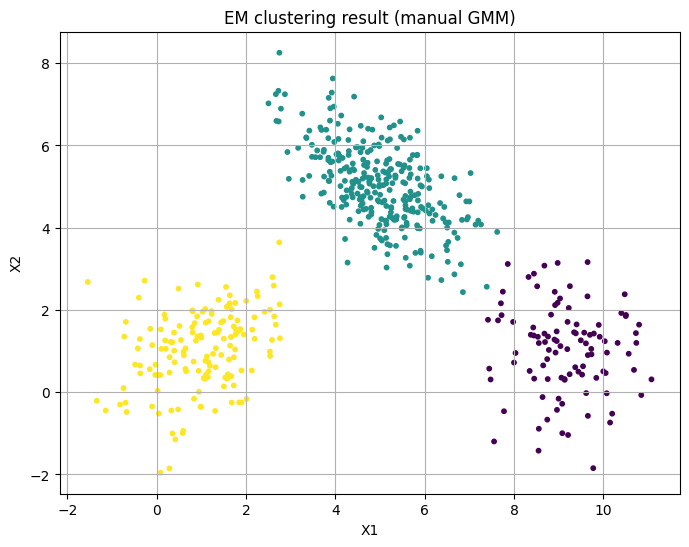

In [16]:
def gaussian_pdf(x, mean, cov):
    d = x.shape[1]
    cov_inv = np.linalg.inv(cov)
    diff = x - mean
    exponent = np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
    denominator = np.sqrt((2 * np.pi)**d * np.linalg.det(cov))
    return exponent / denominator

def initialize_parameters(X, n_components):
    np.random.seed(0)
    n_samples = X.shape[0]
    means = X[np.random.choice(n_samples, n_components, replace=False)]
    covariances = np.array([np.cov(X, rowvar=False)] * n_components)
    weights = np.ones(n_components) / n_components
    return means, covariances, weights

def expectation_step(X, means, covariances, weights):
    n_samples = X.shape[0]
    n_components = means.shape[0]
    responsibilities = np.zeros((n_samples, n_components))
    
    for k in range(n_components):
        responsibilities[:, k] = weights[k] * gaussian_pdf(X, means[k], covariances[k])
    
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

def maximization_step(X, responsibilities):
    n_samples, n_features = X.shape
    n_components = responsibilities.shape[1]
    
    Nk = responsibilities.sum(axis=0)  
    means = (responsibilities.T @ X) / Nk[:, np.newaxis]
    
    covariances = np.zeros((n_components, n_features, n_features))
    for k in range(n_components):
        diff = X - means[k]
        weighted_sum = np.zeros((n_features, n_features))
        for i in range(n_samples):
            weighted_sum += responsibilities[i, k] * np.outer(diff[i], diff[i])
        covariances[k] = weighted_sum / Nk[k]
    
    weights = Nk / n_samples
    return means, covariances, weights

def compute_log_likelihood(X, means, covariances, weights):
    n_samples = X.shape[0]
    n_components = means.shape[0]
    log_likelihood = 0
    for i in range(n_samples):
        tmp = 0
        for k in range(n_components):
            tmp += weights[k] * multivariate_normal.pdf(X[i], means[k], covariances[k])
        log_likelihood += np.log(tmp)
    return log_likelihood

def EM_GMM(X, n_components, tol=1e-4, max_iter=300):
    means, covariances, weights = initialize_parameters(X, n_components)
    log_likelihoods = []
    
    for iteration in range(max_iter):
        # E-step
        responsibilities = expectation_step(X, means, covariances, weights)
        
        # M-step
        means, covariances, weights = maximization_step(X, responsibilities)
        
        # Compute log likelihood
        log_likelihood = compute_log_likelihood(X, means, covariances, weights)
        log_likelihoods.append(log_likelihood)
        
        if iteration > 0 and np.abs(log_likelihood - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iteration}")
            break
    
    return means, covariances, weights, responsibilities

# Run EM manually
means_est, covs_est, weights_est, resp = EM_GMM(X_a, n_components=3)

# Assign predicted labels
y_pred_a = np.argmax(resp, axis=1)

# Plot clustering results
plt.figure(figsize=(8,6))
plt.scatter(X_a[:, 0], X_a[:, 1], c=y_pred_a, cmap='viridis', s=10)
plt.title("EM clustering result (manual GMM)")
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

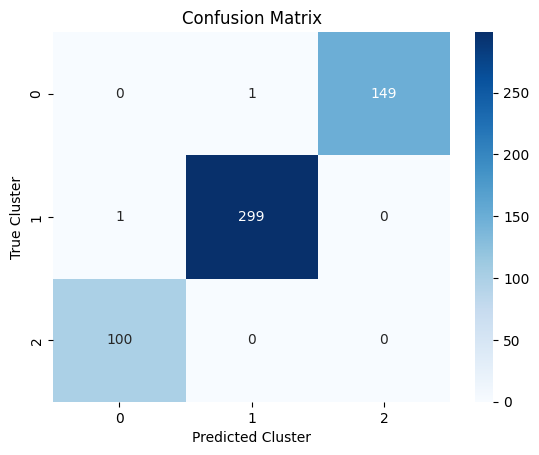


=== Final Parameters ===
Means:
 [[9.16656988 1.02466361]
 [4.98964295 5.03350951]
 [0.99520818 1.02752451]]
Covariances:
 [[[ 0.74386815 -0.07181958]
  [-0.07181958  1.12053933]]

 [[ 0.98183192 -0.58101926]
  [-0.58101926  0.95643721]]

 [[ 0.87680951  0.31068167]
  [ 0.31068167  0.94162033]]]
Weights:
 [0.18267377 0.54634109 0.27098514]


In [17]:
# Confusion Matrix
cm_a = confusion_matrix(y_true_a, y_pred_a)
sns.heatmap(cm_a, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Cluster")
plt.show()

print("\n=== Final Parameters ===")
print("Means:\n", means_est)
print("Covariances:\n", covs_est)
print("Weights:\n", weights_est)